In [28]:
import multiprocessing
import random
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from src.environments import PendulumEnv
from src.utils import Discretizer
from src.sampler import PendulumTrajectorySampler, EpsilonGreedyPendulumTrajectorySampler
from src.trainer import QNetworkTrainer, QNetworkTester
from src.models import PARAFAC

In [29]:
gs = [10.0, 10.0, 10.0, 10.0]
ms = [0.01, 0.1, 0.5, 1.0]
ls = [1.0, 1.0, 0.5, 0.5]

envs = [PendulumEnv(g=gs[i], m=ms[i], l=ls[i]) for i in range(len(gs))]

In [30]:
nS = 20
nA = 10
nT = 4

discretizer = Discretizer(
    min_points_states=[-np.pi, -5],
    max_points_states=[np.pi, 5],
    bucket_states=[nS] * 2,
    min_points_actions=[-2],
    max_points_actions=[2],
    bucket_actions=[nA],
)

In [31]:
gamma = 0.99

In [32]:
def create_target(states_next, rewards, Q, tasks=None):
    if tasks is not None:
        idx_target = torch.cat((tasks.unsqueeze(1), states_next), dim=1)
    else:
        idx_target = states_next

    with torch.no_grad():
        q_target = rewards + gamma * Q(idx_target).max(dim=1).values

    return q_target

def create_idx_hat(states, actions, tasks=None):
    if tasks is not None:
        idx_hat = torch.cat((tasks.unsqueeze(1), states, actions.unsqueeze(1)), dim=1)
    else:
        idx_hat = torch.cat((states, actions.unsqueeze(1)), dim=1)
    return idx_hat

def update_model(s_idx, sp_idx, a_idx, r, Q, opt, tasks=None):
    for factor in Q.factors:
        q_target = create_target(sp_idx, r, Q, tasks)
        idx_hat = create_idx_hat(s_idx, a_idx, tasks)
        q_hat = Q(idx_hat)

        opt.zero_grad()
        loss = torch.nn.MSELoss()(q_hat, q_target)
        loss.backward()

        with torch.no_grad():
            for frozen_factor in Q.factors:
                if frozen_factor is not factor:
                    frozen_factor.grad = None

        opt.step()

def select_action(Q, s_idx, epsilon):
    if np.random.rand() < epsilon:
        idx = np.random.choice(nA)
    else:
        with torch.no_grad():
            idx = Q(s_idx).argmax().item()
    
    a = discretizer.get_action_from_index(idx)
    return a, idx

# 0) Individual tasks

In [106]:
E = 2000
H = 100
lr = 0.01
eps = 1.0
eps_decay = 0.99999
eps_min = 0.1

k = 30
n_upd = nT
n_upd = 1

env_id = 3

def run_test_episode(Q, env_idx):
    with torch.no_grad():
        G = 0
        s, _ = envs[env_idx].reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = envs[env_idx].step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
    return G

In [142]:
#Gs = []
#Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.1)
opt = torch.optim.Adamax(Q.parameters(), lr=lr)
ds = 0
for episode in range(E):
    s, _ = envs[env_id].reset()
    s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
    for h in range(H):
        a, a_idx = select_action(Q, s_idx, eps)
        a_idx = torch.tensor(a_idx).unsqueeze(0)
        sp, r, d, _, _ = envs[env_id].step(a)
        sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

        for _ in range(n_upd):
            update_model(s_idx, sp_idx, a_idx, r, Q, opt)

        s = sp
        s_idx = sp_idx
        eps = max(eps*eps_decay, eps_min)

        # if h % 10 == 0:
    G = run_test_episode(Q, env_id)
    Gs.append(G)
    print(f"\rEpoch: {episode} - Return: {G} - {eps}", end="")
    

Epoch: 1999 - Return: -110.13850515239515 - 0.1

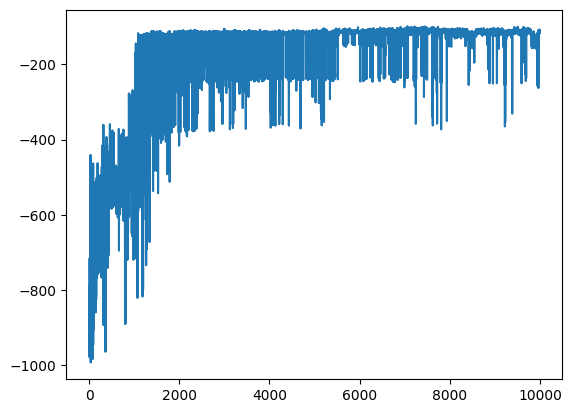

In [144]:
plt.plot(Gs)

In [109]:
As = []
for _ in range(1000):
    with torch.no_grad():
        G = 0
        s, _ = envs[env_id].reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            #print(s, a)
            As.append(a[0])
            sp, r, d, _, _ = envs[env_id].step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx

Text(0.5, 0, 'Torque')

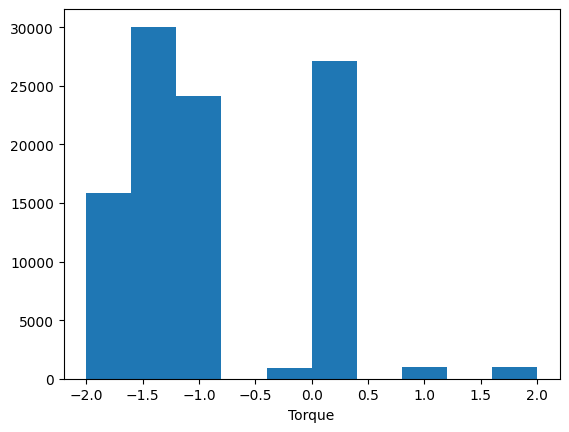

In [110]:
plt.hist(As)
plt.xlabel("Torque")

Text(0.5, 0, 'Torque')

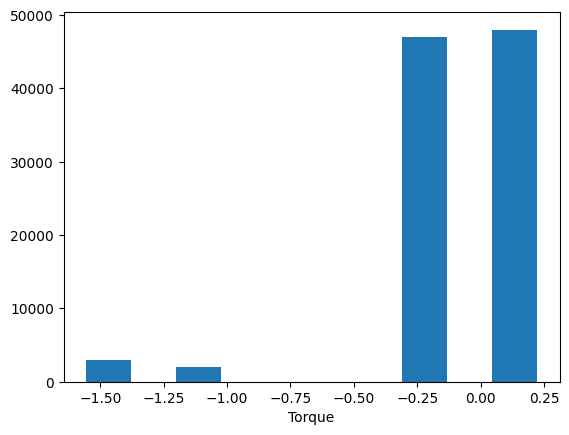

In [71]:
plt.hist(As)
plt.xlabel("Torque")

In [145]:
thetas = []
omegas = []
actions = []
with torch.no_grad():
    G = 0
    s, _ = envs[env_id].reset()
    s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
    for h in range(H):
        a_idx = Q(s_idx).argmax().item()
        a = discretizer.get_action_from_index(a_idx)
        a_idx = torch.tensor(a_idx).unsqueeze(0)
        print(s, a)
        thetas.append(s[0]), omegas.append(s[1]), actions.append(a[0])
        sp, r, d, _, _ = envs[env_id].step(a)
        sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

        G += r

        if d:
            break

        s = sp
        s_idx = sp_idx

[3.1415927  0.06513514] [-2.]
[ 3.0848494 -1.1348648] [-2.]
[ 2.9723597 -2.2497957] [-2.]
[ 2.812502  -3.1971562] [-1.55555556]
[ 2.6302161 -3.6457152] [-2.]
[ 2.4246337 -4.111648 ] [-2.]
[ 2.2083335 -4.326005 ] [-2.]
[ 1.9923005 -4.3206587] [-2.]
[ 1.7847031 -4.151947 ] [-2.]
[ 1.5903965 -3.8861332] [-2.]
[ 1.4110755 -3.5864213] [-2.]
[ 1.2457998 -3.3055139] [-1.55555556]
[ 1.1049312 -2.8173695] [-2.]
[ 0.9710703 -2.6772194] [-0.66666667]
[ 0.87912107 -1.838984  ] [-2.]
[ 0.7849353 -1.8837161] [-2.]
[ 0.6837579 -2.023547 ] [-2.]
[ 0.56995887 -2.2759812 ] [1.11111111]
[ 0.52996296 -0.7999183 ] [-0.66666667]
[ 0.5078797  -0.44166622] [-1.55555556]
[ 0.4756041 -0.6455111] [-0.66666667]
[ 0.4576692 -0.3586977] [-1.55555556]
[ 0.42620704 -0.6292435 ] [-0.66666667]
[ 0.40575138 -0.40911326] [-1.55555556]
[ 0.36823222 -0.7503827 ] [-0.66666667]
[ 0.3377106 -0.6104326] [-0.66666667]
[ 0.31203857 -0.51344085] [-0.66666667]
[ 0.2893915  -0.45294175] [-0.66666667]
[ 0.26814708 -0.42488816] [-0.6

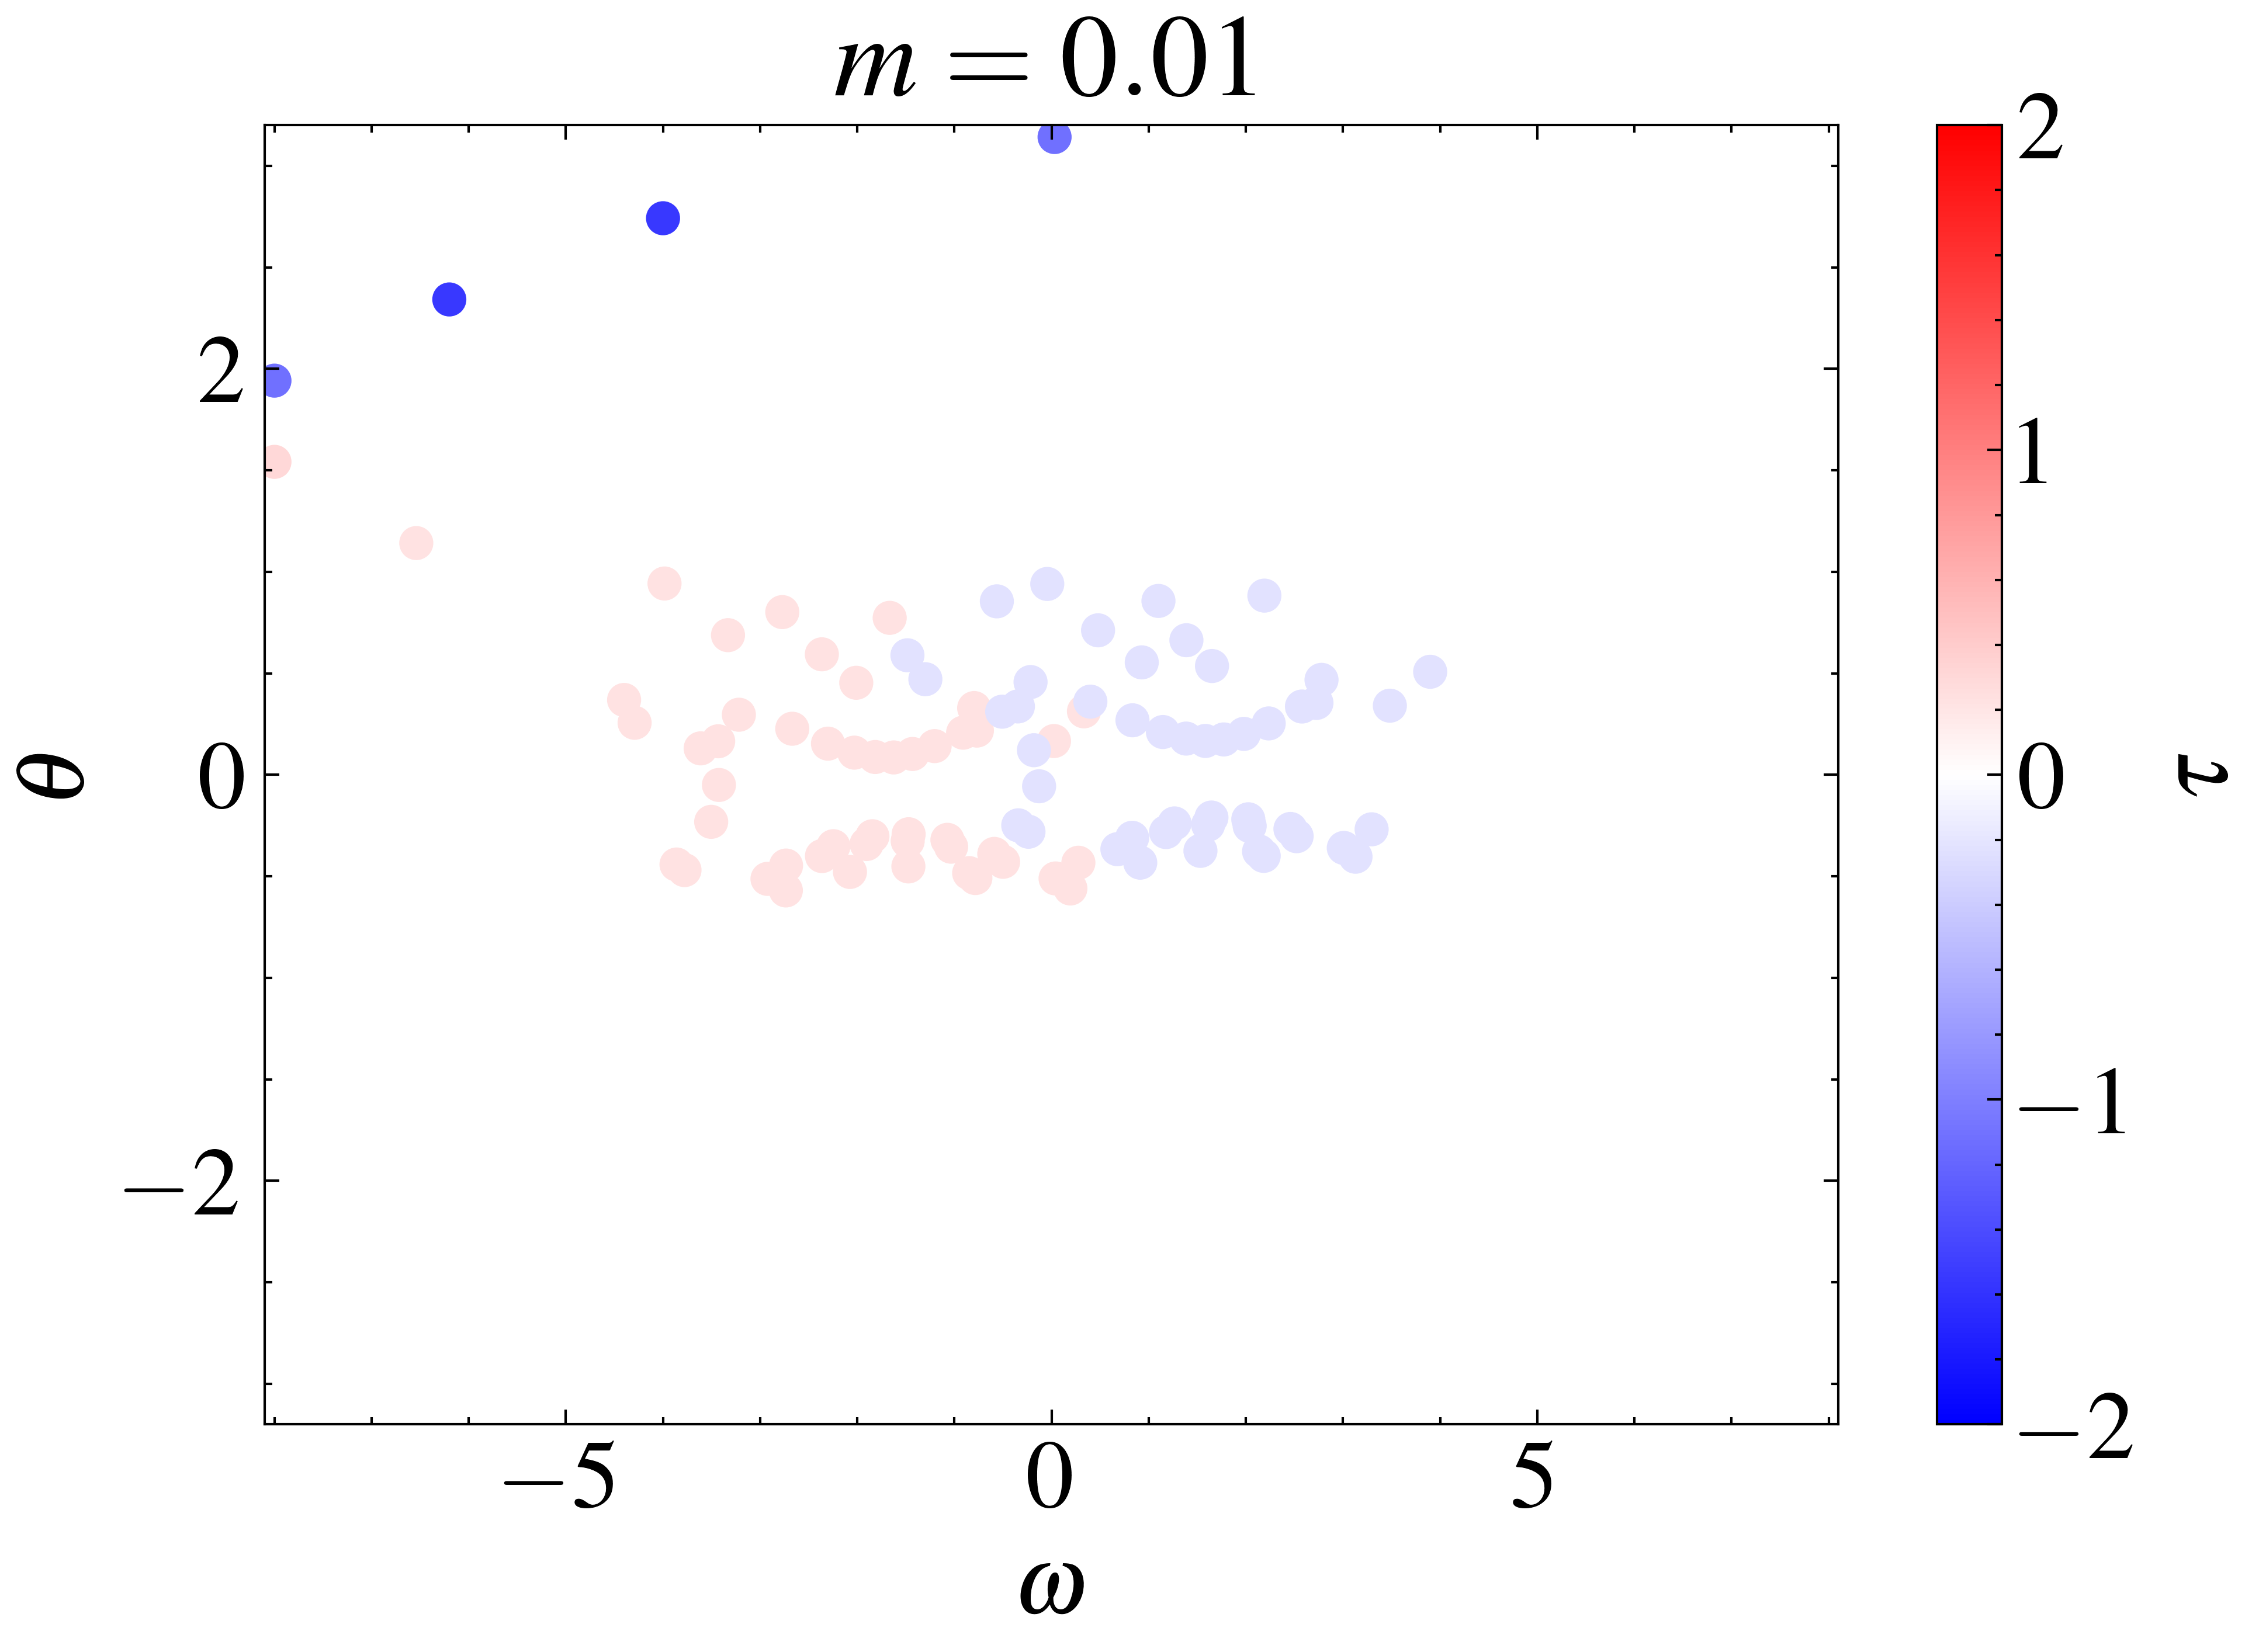

In [105]:
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=[7, 5])

    plt.scatter(omegas, thetas, c=actions, cmap='bwr', vmin=-2, vmax=2)
    colorbar = plt.colorbar()
    colorbar.set_label("$\\tau$")
    plt.xlabel("$\\omega$")
    plt.ylabel("$\\theta$")
    plt.xlim(-8.1, 8.1)
    plt.ylim(-3.2, 3.2)
    plt.tight_layout()
    plt.title("$m=0.01$")
    plt.show()

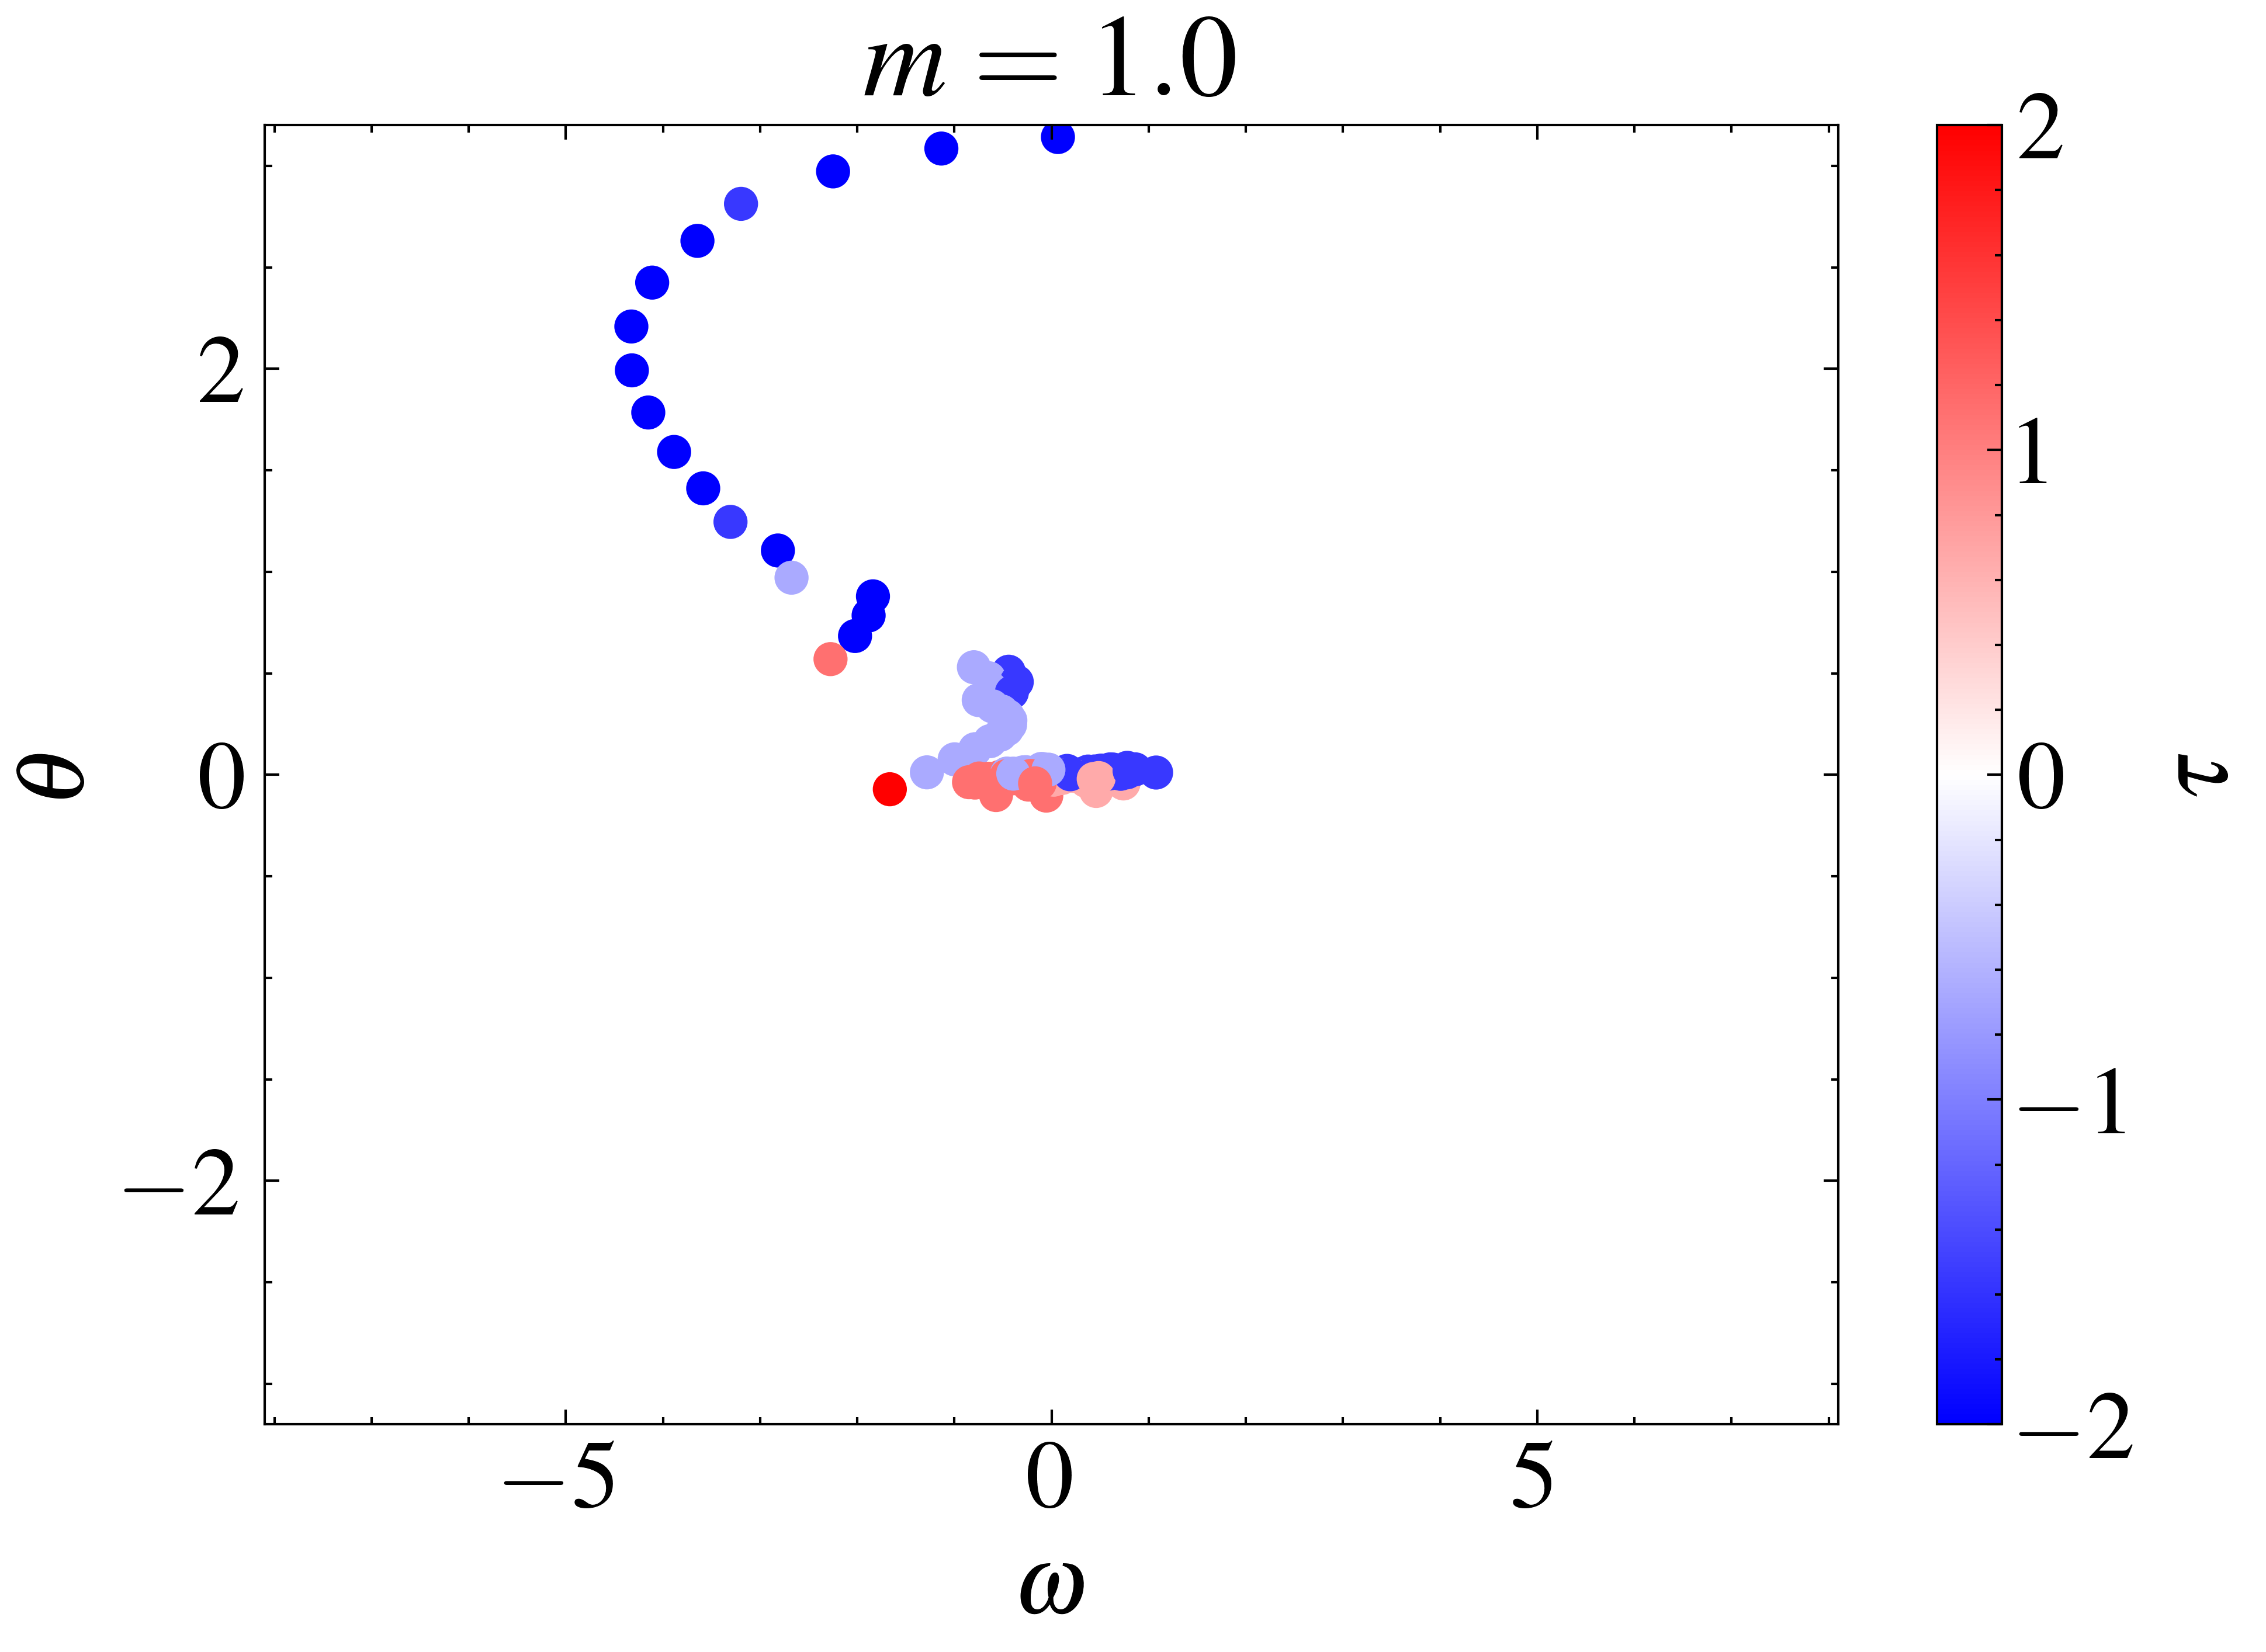

In [147]:
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=[7, 5])

    plt.scatter(omegas, thetas, c=actions, cmap='bwr', vmin=-2, vmax=2)
    colorbar = plt.colorbar()
    colorbar.set_label("$\\tau$")
    plt.xlabel("$\\omega$")
    plt.ylabel("$\\theta$")
    plt.xlim(-8.1, 8.1)
    plt.ylim(-3.2, 3.2)
    plt.tight_layout()
    plt.title("$m=1.0$")
    plt.show()

Text(0, 0.5, 'Posición angular')

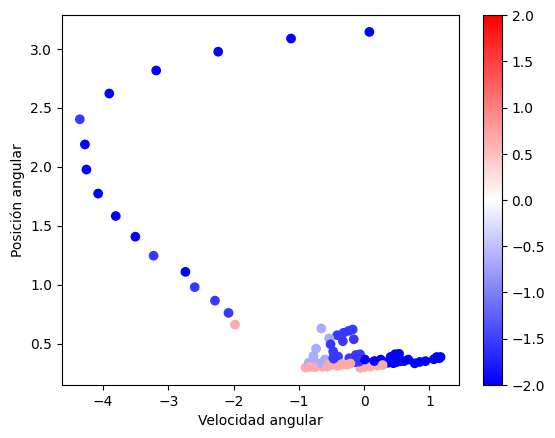

In [140]:
plt.scatter(omegas, thetas, c=actions, cmap='bwr', vmin=-2, vmax=2)
plt.colorbar()
plt.xlabel("Velocidad angular")
plt.ylabel("Posición angular")

# 1) Multi-task

In [6]:
E = 1_000
H = 100
lr = 0.01
eps = 1.0
eps_decay = 0.99999
eps_min = 0.1
k = 30

def run_test_episode(Q, env_idx):
    with torch.no_grad():
        G = 0
        s, _ = envs[env_idx].reset()
        s_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = envs[env_idx].step(a)
            sp_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
    return G

In [7]:
# SEQUENTIAL SAMPLING
Q = PARAFAC(dims=[nT, nS, nS, nA], k=k, scale=0.1)
opt = torch.optim.Adamax(Q.parameters(), lr=lr)
Gs = [[] for _ in range(nT)]
for episode in range(E):
    for env_idx, env in enumerate(envs):
        s, _ = env.reset()
        s_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = env.step(a)
            sp_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(sp)).unsqueeze(0)

            s_idx_train = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
            sp_idx_train = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)
            update_model(s_idx_train, sp_idx_train, a_idx, r, Q, opt, tasks=torch.tensor([env_idx]))
            # Q.normalize_factors()

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)

        G = run_test_episode(Q, env_idx)
        Gs[env_idx].append(G)
    print(f"\rEpoch: {episode} - Return: {[Gs[i][-1] for i in range(nT)]} - {eps}", end="")

Epoch: 999 - Return: [-120.98102523321806, -88.41563039813167, -89.61490383867684, -120.98458413046974] - 0.1.12576907460938283

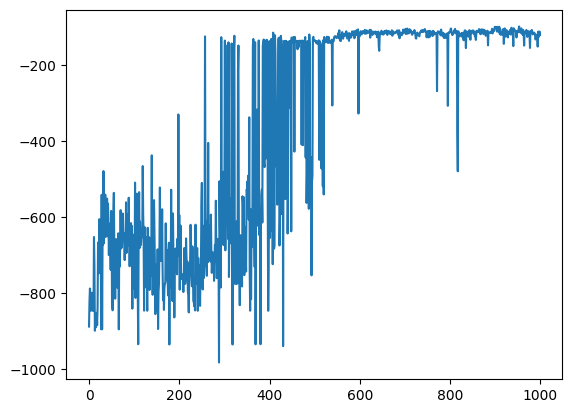

In [8]:
testid = 3
plt.plot(Gs[testid])

# 2) Single agent

In [35]:
E = 1_000
H = 100
lr = 0.01
eps = 1.0
eps_decay = 0.99999
eps_min = 0.1
k = 20

def run_test_episode(Q, env_idx):
    with torch.no_grad():
        G = 0
        s, _ = envs[env_idx].reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = envs[env_idx].step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
    return G

In [36]:
# SEQUENTIAL SAMPLING
Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.1)
opt = torch.optim.Adamax(Q.parameters(), lr=lr)
Gs = [[] for _ in range(nT)]
for episode in range(E):
    for env_idx, env in enumerate(envs):
        s, _ = env.reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = env.step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            s_idx_train = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
            sp_idx_train = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)
            update_model(s_idx_train, sp_idx_train, a_idx, r, Q, opt, tasks=None)

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)

        G = run_test_episode(Q, env_idx)
        Gs[env_idx].append(G)
    print(f"\rEpoch: {episode} - Return: {[Gs[i][-1] for i in range(nT)]}", end="")

Epoch: 999 - Return: [-176.99311055165157, -136.7505194536148, -100.48276109809937, -577.7694563099669]]]

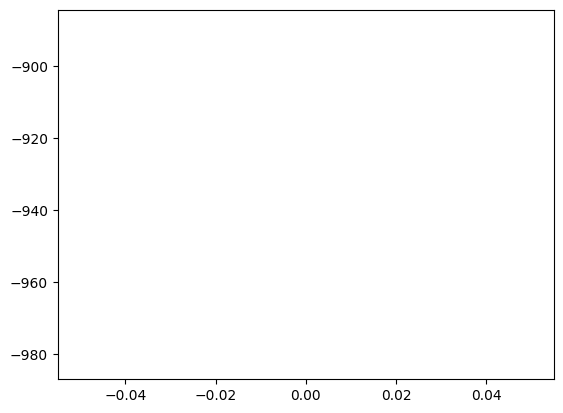

In [22]:
testid = 2
plt.plot(Gs[testid])

In [60]:
G = run_test_episode(Q, env_idx)
G

-14.79880540151708

In [14]:
env_idx = 1
with torch.no_grad():
    G = 0
    s, _ = envs[env_idx].reset()
    s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
    for h in range(H):
        a_idx = Q(s_idx).argmax().item()
        a = discretizer.get_action_from_index(a_idx)
        print(a)
        a_idx = torch.tensor(a_idx).unsqueeze(0)
        sp, r, d, _, _ = envs[env_idx].step(a)
        sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

        G += r

        if d:
            break

        s = sp
        s_idx = sp_idx
G

[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]


-10

In [ ]:
E = 50
H = 200
lr = 0.01
eps = 0.0
eps_decay = 1.0
eps_min = 0.0
gamma = 0.99
k = 20

def run_test_episode(Q):
    Gs = []
    for id, env in enumerate(envs):
        G = 0
        s, _ = env.reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = env.step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
        Gs.append(G)
    return Gs

# 1) Single-task all

In [115]:
E = 1
H = 100
nS = 20
nA = 20
gs = [1.0, 2.0, 5.0, 10.0]
m = 1
l = 1
nT = len(gs)

k = 100
lr = 0.001
gamma = 0.99
epochs = 1

In [37]:
n= 1

np.random.seed(n)
random.seed(n)
torch.manual_seed(n)

In [14]:
epsilon = 0.99
decay = 0.999
Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.1)
trainer = QNetworkTrainer(Q, lr, gamma)
res = []
for _ in range(2_000):
    sampler = EpsilonGreedyPendulumTrajectorySampler(gs, m, l, E, H, nS, nA, epsilon, Q, multi_task=False)
    sampler.sample_data()

    dataset_mult = sampler.get_trajectories_dataset()
    loader_mult = DataLoader(dataset_mult, batch_size=128, shuffle=True)

    trainer.train(loader_mult, epochs, use_tasks=False)
    epsilon *= decay

    tester = QNetworkTester(Q, nS, nA, gs, m, l, H)
    res.append(tester.test(task_id=None, multi_task=False))
res = np.array(res)

Epoch: 0 - Loss: 16.358794176015476

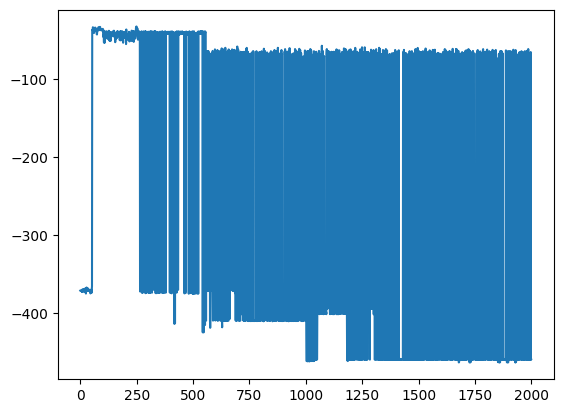

In [25]:
plt.plot(res[:, 0])

In [39]:
res = []
for _ in range(100):
    tester = QNetworkTester(Q, nS, nA, gs, m, l, H)
    res.append(tester.test(task_id=None, multi_task=False))
res = np.array(res)

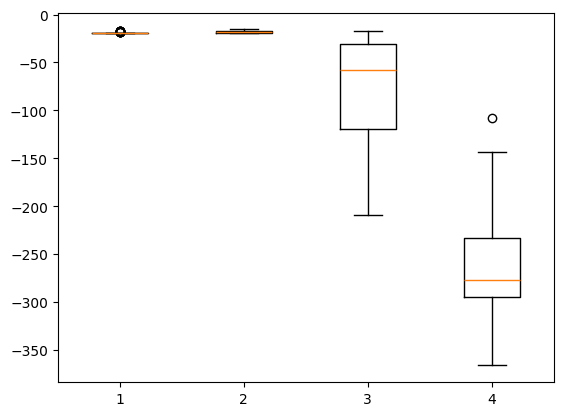

In [40]:
plt.boxplot([res[:, 0], res[:, 1], res[:, 2], res[:, 3]])
plt.show()

# 2) Multi-task

In [8]:
E = 1
H = 100
nS = 10
nA = 10
gs = [1.0, 1.0, 1.0, 1.0]
m = 1
l = 1
nT = len(gs)

k = 20
lr = 0.001
gamma = 0.99
epochs = 1

In [9]:
n= 3

np.random.seed(n)
random.seed(n)
torch.manual_seed(n)

In [12]:
epsilon = 1.0
decay = 0.9999
Q = PARAFAC(dims=[nT, nS, nS, nA], k=k, scale=0.1, bias=0.0)
trainer = QNetworkTrainer(Q, lr, gamma)
res = []
for e in range(10_000):
    sampler = EpsilonGreedyPendulumTrajectorySampler(gs, m, l, E, H, nS, nA, epsilon, Q, multi_task=True)
    sampler.sample_data()

    dataset_mult = sampler.get_trajectories_dataset()
    loader_mult = DataLoader(dataset_mult, batch_size=1, shuffle=True)

    trainer.train(loader_mult, epochs, use_tasks=True, mono=True)
    epsilon *= decay

    tester = QNetworkTester(Q, nS, nA, gs, m, l, H)
    res.append(tester.test(task_id=None, multi_task=True))

    print(f"\rEpoch: {e} - Return: {res[-1]}", end="")
res = np.array(res)

Epoch: 9999 - Return: [-339.580675496913, -279.77236269624063, -626.8362096502551, -149.6583643619903]1]]]

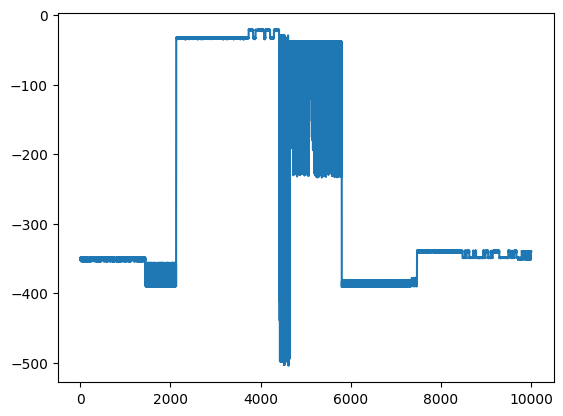

In [13]:
res = np.array(res)
plt.plot(res[:,0])

In [12]:
res = []
for _ in range(100):
    tester = QNetworkTester(Q, nS, nA, gs, m, l, H)
    res.append(tester.test(task_id=None, multi_task=True))
res = np.array(res)

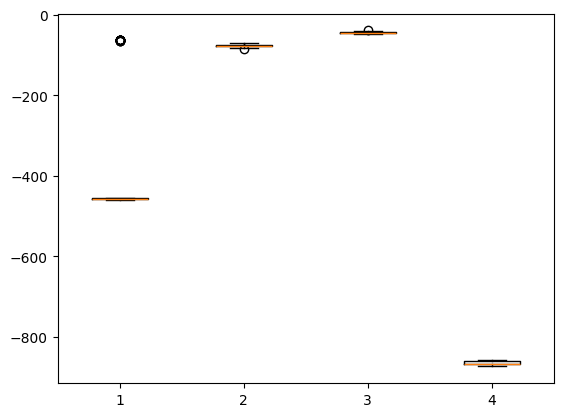

In [13]:
plt.boxplot([res[:, 0], res[:, 1], res[:, 2], res[:, 3]])
plt.show()

In [149]:
arr_single_exp0 = np.load("results/e1_single_env0.npy")
arr_single_exp1 = np.load("results/e1_single_env1.npy")
arr_single_exp2 = np.load("results/e1_single_env2.npy")
arr_single_exp3 = np.load("results/e1_single_env3.npy")

arrays = [arr_single_exp0, arr_single_exp1, arr_single_exp2, arr_single_exp3]
arr_single = np.stack(arrays, axis=0)

In [150]:
arr_multi = np.load("results/e2_multi.npy")
arr_single_all = np.load("results/e3_single_all.npy")

In [151]:
arr_single_mean = np.median(arr_single, axis=1)
arr_single_std = np.std(arr_single, axis=1)
arr_single_std = np.percentile(arr_single, q=75, axis=1) - np.percentile(arr_single, q=25, axis=1)

arr_multi_mean = np.median(arr_multi, axis=0)
arr_multi_std = np.std(arr_multi, axis=0)
arr_multi_std = np.percentile(arr_multi, q=75, axis=0) - np.percentile(arr_multi, q=25, axis=0)

arr_single_all_mean = np.median(arr_single_all, axis=0)
arr_single_all_std = np.std(arr_single_all, axis=0)
arr_single_all_std = np.percentile(arr_single_all, q=75, axis=0) - np.percentile(arr_single_all, q=25, axis=0)

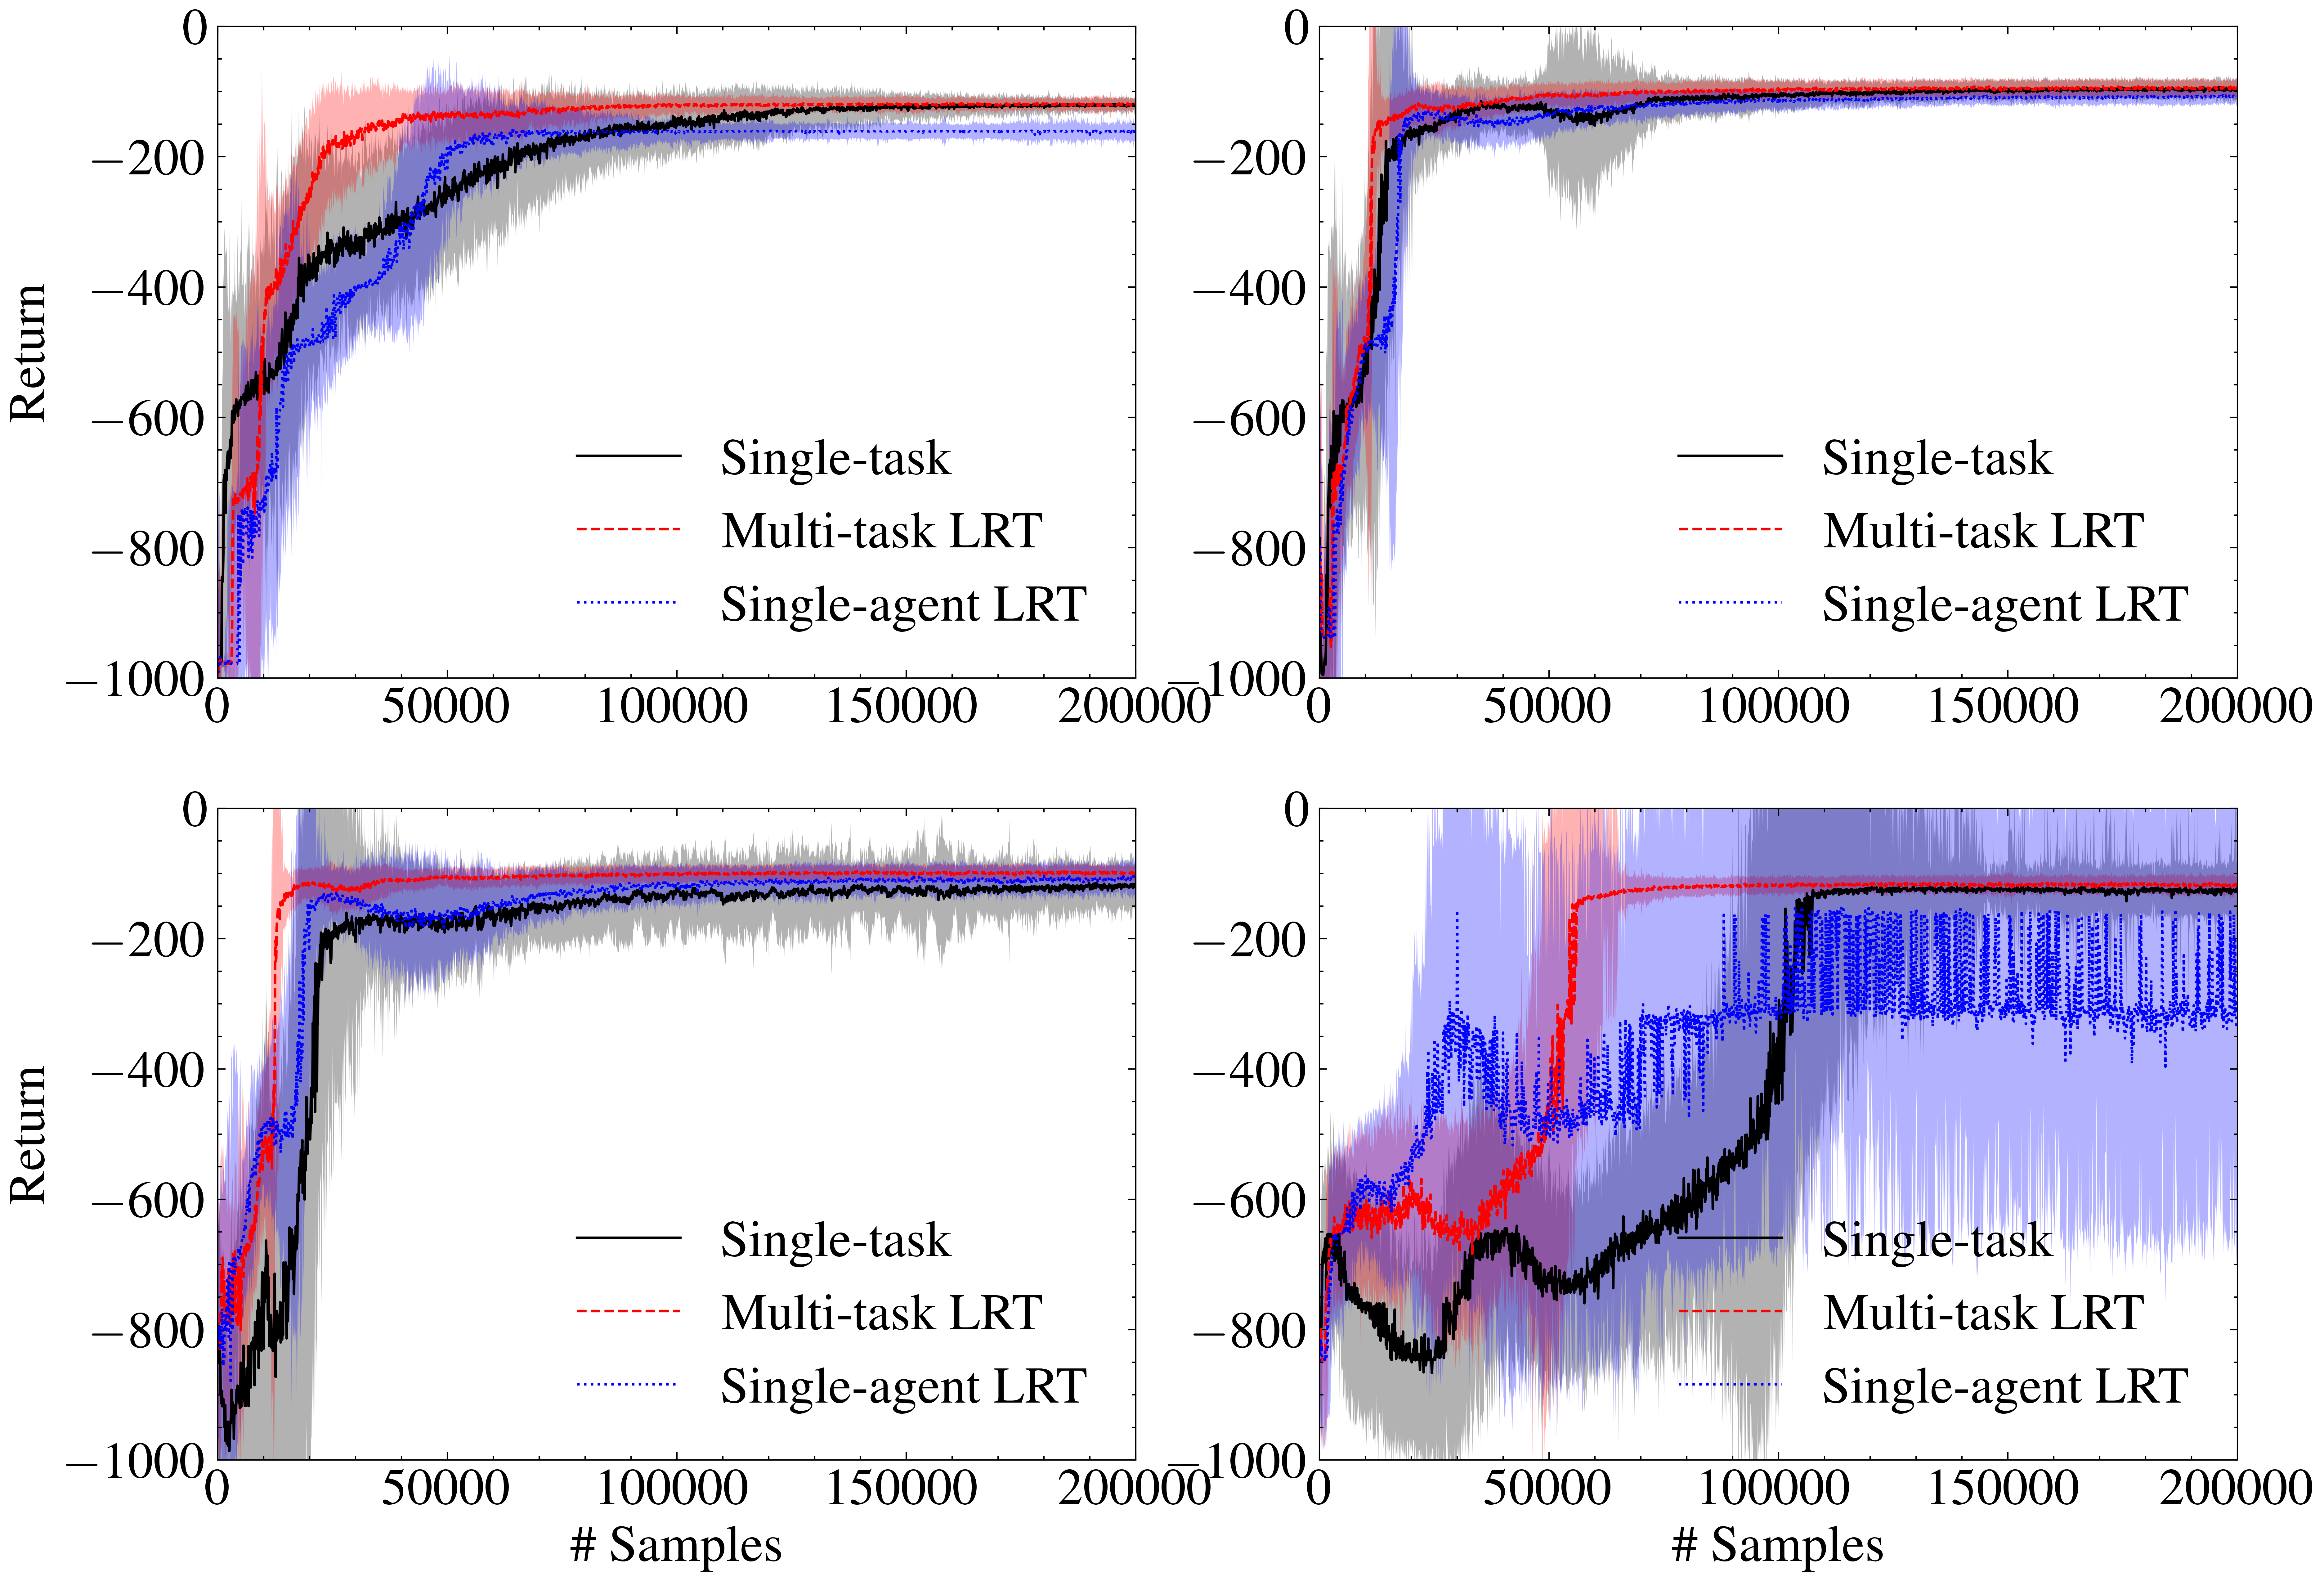

<Figure size 3000x1800 with 0 Axes>

<Figure size 3000x1800 with 0 Axes>

<Figure size 3000x1800 with 0 Axes>

<Figure size 3000x1800 with 0 Axes>

In [168]:
import numpy as np
import matplotlib.pyplot as plt


matrices = [arr_single_mean, arr_multi_mean, arr_single_all_mean]
stds = [arr_single_std, arr_multi_std, arr_single_all_std]
labels = ['Single-task', 'Multi-task LRT', 'Single-agent LRT']

with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 20})
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[14, 10])

    axes = axes.flatten()

    for i in range(4):
        plt.figure(figsize=(5, 3))
        for j, (matrix, std) in enumerate(zip(matrices, stds)):
            time = np.arange(0, 100 * matrix.shape[1], 100)
            mean = matrix[i]
            std_dev = std[i]

            axes[i].plot(time, mean, label=labels[j])
            axes[i].fill_between(time, mean - std_dev, mean + std_dev, alpha=0.3)

        #axes[i].title(f'Task {i}')
        axes[i].set_xlim(0, 200_000)
        axes[i].set_ylim(-1_000, 0)
        axes[i].set_xticks([0, 50_000, 100_000, 150_000, 200_000])
        axes[i].legend()
    axes[0].set_ylabel('Return')
    axes[2].set_ylabel('Return')
    axes[2].set_xlabel('$\#$ Samples')
    axes[3].set_xlabel('$\#$ Samples')
    plt.tight_layout()
    plt.show()
